In [13]:
#import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, tqdm_notebook
#from joblib import Parallel, delayed
#from skimage.io import imread
#from skimage.transform import resize
#import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images

#%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout,AdaptiveAvgPool2d
from torch.optim import Adam, SGD

# torchvision for pre-trained models
from torchvision import models
from torchsummary import summary


import shutil, sys   
#from google.colab.patches import cv2_imshow
import copy



#from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
#plt.ion()  

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Change to fit hardware
BATCH_SIZE = 64
print_every = 50
MODEL = 'alexnet'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/scratch/kv942/ccm_proj/datadir_rnd/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

train_loader = DataLoader(image_datasets['train'],
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          )
val_loader = DataLoader(image_datasets['val'],
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         )
test_loader = DataLoader(image_datasets['test'],
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          )

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [6]:
dataset_sizes

{'train': 38691, 'val': 4836}

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [8]:
# inputs, classes = next(iter(dataloaders['train']))
# out = torchvision.utils.make_grid(inputs)
#imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    # Training steps
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        model.train()
        
        running_loss = 0.0   
        running_corrects = 0
        number_training_steps = 0
        # Iterate over data.
        for batch_id, (inputs, labels) in enumerate(train_loader):
            
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            outputs = model(inputs)
            model.zero_grad() #same as optimizer.zero_grad()
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() # sum up loss of all minibatches
            
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).cpu()
            
            loss.backward()
            optimizer.step()
            number_training_steps+=1
            
            if batch_id % print_every == 0:
                # report performance
                print('Train [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.item()))

        scheduler.step()
        
        epoch_trainloss = running_loss / number_training_steps
        #train_loss_list.append(epoch_trainloss)
        epoch_trainaccuracy = running_corrects.double() / len(train_loader.dataset)
        #train_acc_list.append(epoch_trainaccuracy)
        
        # report performance
        print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        epoch_trainloss, running_corrects, len(train_loader.dataset),
        100. * epoch_trainaccuracy))
        
        
    
        # Evaluate after every epoch
        
        model.eval()
        running_loss = 0
        running_corrects = 0

        with torch.no_grad():
            
            number_val_steps = 0
            for batch_id, (inputs, labels) in enumerate(val_loader):
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                #print("labels = ", labels)
                outputs = model(inputs)
                #print("outputs = ", outputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() # sum up loss of all minibatches
                number_val_steps += 1
                
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data).cpu()
                
            
            epoch_valloss = running_loss / number_val_steps
            #val_loss_list.append(epoch_valloss)
            epoch_valaccuracy = running_corrects.double() / len(val_loader.dataset)
            #val_acc_list.append(epoch_valaccuracy)
            #auc = roc_auc_score(truths, predictions)
            
            print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            epoch_valloss, running_corrects, len(val_loader.dataset),
            100. * epoch_valaccuracy))
    
        # deep copy the model
        if epoch_valaccuracy > best_acc:
                best_acc = epoch_valaccuracy
                best_model_wts = copy.deepcopy(model.state_dict())
    
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
def test_performance(model):
    running_loss = 0
    running_corrects = 0
    with torch.no_grad():

        number_test_steps = 0
        for batch_id, (inputs, labels) in enumerate(test_loader):
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            #print("labels = ", labels)
            outputs = model(inputs)
            #print("outputs = ", outputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() # sum up loss of all minibatches
            number_test_steps += 1

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).cpu()


        epoch_testloss = running_loss / number_test_steps
        #val_loss_list.append(epoch_valloss)
        epoch_testaccuracy = running_corrects.double() / len(test_loader.dataset)
        #val_acc_list.append(epoch_valaccuracy)
        #auc = roc_auc_score(truths, predictions)

        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch_testloss, running_corrects, len(test_loader.dataset),
        100. * epoch_testaccuracy))


# 3Layer CNN

In [14]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.avg = AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = self.layer3(out)
        out = self.avg(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(len(class_names))

In [15]:
if torch.cuda.device_count() > 1:
    print("we have multiple GPUs..")
    model = nn.DataParallel(model)


In [16]:
model = model.to(device)

In [17]:
torch.cuda.empty_cache()

In [18]:
summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
       BatchNorm2d-2         [64, 64, 224, 224]             128
              ReLU-3         [64, 64, 224, 224]               0
            Conv2d-4        [64, 128, 224, 224]          73,856
       BatchNorm2d-5        [64, 128, 224, 224]             256
              ReLU-6        [64, 128, 224, 224]               0
         MaxPool2d-7        [64, 128, 112, 112]               0
 AdaptiveAvgPool2d-8            [64, 128, 1, 1]               0
            Linear-9                    [64, 8]           1,032
Total params: 77,064
Trainable params: 77,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 36.75
Forward/backward pass size (MB): 14896.07
Params size (MB): 0.29
Estimated Total Size (MB): 14933.11
------------------------------------

In [19]:
num_epochs = 25

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=num_epochs)

Epoch:  0
Train [0/38691 (0%)]	Loss: 2.072790
Train [3200/38691 (8%)]	Loss: 1.960735
Train [6400/38691 (17%)]	Loss: 1.909036
Train [9600/38691 (25%)]	Loss: 1.889530
Train [12800/38691 (33%)]	Loss: 1.859511
Train [16000/38691 (41%)]	Loss: 1.908054
Train [19200/38691 (50%)]	Loss: 1.884003
Train [22400/38691 (58%)]	Loss: 1.903271
Train [25600/38691 (66%)]	Loss: 1.885284
Train [28800/38691 (74%)]	Loss: 1.742159
Train [32000/38691 (83%)]	Loss: 1.906980
Train [35200/38691 (91%)]	Loss: 1.756655
Train [38400/38691 (99%)]	Loss: 1.842178
Train set: Average loss: 1.8751, Accuracy: 11012/38691 (28.46%)
Validation set: Average loss: 1.8586, Accuracy: 1307/4836 (27.03%)

Epoch:  1
Train [0/38691 (0%)]	Loss: 1.760779
Train [3200/38691 (8%)]	Loss: 1.922199
Train [6400/38691 (17%)]	Loss: 1.761991
Train [9600/38691 (25%)]	Loss: 1.808855
Train [12800/38691 (33%)]	Loss: 1.669739
Train [16000/38691 (41%)]	Loss: 1.801994
Train [19200/38691 (50%)]	Loss: 1.829875
Train [22400/38691 (58%)]	Loss: 1.786585
Train

In [22]:
torch.save(model.state_dict(), "./model_results/.pth")

In [24]:
from matplotlib import pyplot as plt

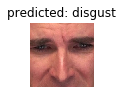

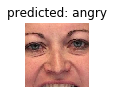

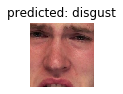

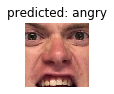

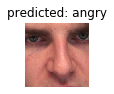

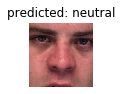

In [29]:
visualize_model(model)

# Test Performance


In [35]:
test_performance(model)

Test set: Average loss: 0.1706, Accuracy: 4563/4837 (94.34%)

